# Cross-validation strategies in QSPR modelling of chemical reactions

* &copy;&nbsp; 2021 Assima Rakhimbekova
* &copy;&nbsp; 2021 Ramil Nugmanov

The notebook illustrates how the quantitative structure-property relationship (QRPR) model can be&nbsp;used to&nbsp;predict rate constants of&nbsp;reactions (logK) using bimolecular nucleophilic substitution reactions dataset 
by&nbsp;[Gimadiev et&nbsp;al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/minf.201800104) as&nbsp;an&nbsp;example. <br>
We&nbsp;consider cross-validation of&nbsp;the QRPR models for reactions and show that the conventional k-fold cross-validation procedure gives an &lsquo;optimistically&rsquo; biased assessment of&nbsp;prediction performance. To&nbsp;address this issue, we&nbsp;suggest two strategies of&nbsp;model cross-validation, &lsquo;**transformation-out&rsquo; CV**, and &lsquo;**solvent-out&rsquo; CV**. Unlike the conventional k-fold cross-validation approach that does not consider the nature of&nbsp;objects, the proposed procedures provide an&nbsp;unbiased estimation of&nbsp;the predictive performance of&nbsp;the models for novel types of&nbsp;structural transformations in&nbsp;chemical reactions and reactions going under new conditions.

* [Loading dataset](#Loading-dataset)<br>
* [Featurize the reactions using StructureFingerprint linear fingerprints of Condensed Graph of Reactions](#Featurize-the-reactions-using-StructureFingerprint-linear-fingerprints-of-Condensed-Graph-of-Reactions)<br>
* [Train and predict QRPR model](#Train-and-predict-QRPR-model)<br>
    * [k-Fold CV](#k-Fold-CV)<br>
    * [Transformation-out CV](#Transformation-out-CV)<br>
    * [Solvent-out CV](#Solvent-out-CV)<br>

## Loading dataset

In [2]:
from CIMtools.datasets import load_sn2

In [3]:
dataset, Y = load_sn2(return_X_y=True) # dataset - array of reactions, 
                                       # Y (what we want to predict) - array of logK

In [4]:
dataset[0]

In [5]:
dataset[0].meta # temperature (K), 
                # logK - Y (what we want to predict), 
                # additive.1 - solvent,  
                # amount.1 - the molar ratio of organic solvent (1.0 for pure solvent)

{'temperature': '298.15',
 'logK': '-4.19',
 'additive.1': 'water',
 'amount.1': '1.0'}

In [6]:
print('Number of reactions = {}'.format(len(dataset)))
print('Number of transformation = {}'.format(len(set(dataset))))

Number of reactions = 4830
Number of transformation = 1352


## Featurize the reactions using StructureFingerprint linear fingerprints of Condensed Graph of Reactions

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from CIMtools.preprocessing import CGR, EquationTransformer, SolventVectorizer
from CIMtools.preprocessing.conditions_container import DictToConditions, ConditionsToDataFrame
from CIMtools.utils import iter2array
from StructureFingerprint import LinearFingerprint
from numpy import array
from math import sqrt

Helper function for sklearn Pipeline

In [8]:
def extract_meta(x):
    return [y[0].meta for y in x]

Create two Pipelines for processing structures and conditions.

The following transformers are used: <br>
<ol>
<li><b>ColumnTransformer</b> assigns specific transformers to&nbsp;each column.</li> <br>
<li><b>EquationTransformer</b> converts the temperature to&nbsp;the required form</li> <br>
<li><b>SolventVectorizer</b> converts the name of&nbsp;the solvent into 13&nbsp;descriptors. You can specify which of&nbsp;the 13&nbsp;descriptors to&nbsp;use.</li> <br>
<li>If&nbsp;we&nbsp;have additional descriptors, such as&nbsp;the molar ratio of&nbsp;organic solvent, then we&nbsp;can not use transformers, but specify &rsquo;passthrough&rsquo;. For example, for molar ratio of&nbsp;organic solvent it&nbsp;would look like this: (&rsquo;amount&rsquo;, &rsquo;passthrough&rsquo;, [&rsquo;solvent_amount.1&prime;])</li> <br>
<li><b>FunctionTransformer</b> constructs a&nbsp;transformer from an&nbsp;arbitrary callable (see more about <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html'>FunctionTransformer</a>) in&nbsp;the official site)</li> <br>
<li><b>DictToConditions</b>&nbsp;&mdash; helper for mapping dictionary of&nbsp;conditions to&nbsp;conditions objects. It&nbsp;also self-tests, that&nbsp;is, it&nbsp;will check all conditions for validity. <b> DictToConditions </b> implements: temperature, pressure, solvent and molar fraction of&nbsp;solvents. In&nbsp;order to&nbsp;use&nbsp;it, you need to&nbsp;register how each type of&nbsp;condition is&nbsp;indicated in&nbsp;the initial data, and in&nbsp;the case of&nbsp;solvents, you need to&nbsp;indicate a&nbsp;list of&nbsp;the solvent&rsquo;s names and the names of&nbsp;its molar fraction. Moreover, the names of&nbsp;solvents and molar fractions must be&nbsp;specified in&nbsp;the same order. For example, solvents = [&rsquo;additive.1&prime;, &rsquo;additive.2&prime;] and amounts (means molar fractions) = [&rsquo;amount.1&prime;, &rsquo;amount.2&prime;].</li> <br>
<li><b>ConditionsToDataFrame</b>&nbsp;&mdash; a&nbsp;special transformer from CIMtools that turns the list of&nbsp;conditions into a&nbsp;DataFrame, that&nbsp;is, it&nbsp;unpacks the conditions into columns. By&nbsp;default, it&nbsp;will pull out temperature, pressure and solvent.</li>
</ol><br>

At&nbsp;the output of&nbsp;the next cell, we&nbsp;get the list of&nbsp;condition objects.

In [9]:
features = ColumnTransformer([('temp', EquationTransformer('1/x'), ['temperature']),
                              ('solvent', SolventVectorizer(), ['solvent.1']),
                              ('amount', 'passthrough', ['solvent_amount.1'])])

conditions = Pipeline([('extract_meta', FunctionTransformer(extract_meta)),
                       ('parse_meta', DictToConditions(solvents=('additive.1',), 
                                                       temperature='temperature', 
                                                       amounts=('amount.1',))),
                       ('convert', ConditionsToDataFrame()),
                       ('featurize', features)])

The next cell processes the structures of reactions.

In [10]:
graph = Pipeline([('CGR', CGR()),
                  ('convert', FunctionTransformer(iter2array)),
                  ('fingerprint', LinearFingerprint(min_radius=2, max_radius=5, length=1024))])

We combine two Pipelines for processing the structures of reactions and the conditions.

In [11]:
pp = ColumnTransformer([('conditions', conditions, [0]),
                        ('structure', graph, [0])])

We get the descriptors of the CGR of reactions and the conditions

In [12]:
X = pp.fit_transform([[x] for x in dataset])

## Train and predict QRPR model

### k-Fold CV

In [13]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=1)

In&nbsp;the cross-validation procedure (we call it as **&rsquo;Reaction-out&rsquo; CV**), the initial data set is&nbsp;divided into a&nbsp;given number of&nbsp;subsets, corresponding to&nbsp;the desired number of&nbsp;folds. **&rsquo;Reaction-out&rsquo; CV**&nbsp;approach is&nbsp;simply a&nbsp;regular five times repeated five-fold CV. The sizes of&nbsp;test sets in&nbsp;it&nbsp;are almost equal.

In [14]:
from sklearn.ensemble import RandomForestRegressor

Y_pred, Y_true = [], []
for train_index, test_index in cv.split(X):
    x_train = X[train_index]
    x_test = X[test_index]
    y_train = Y[train_index]
    y_test = Y[test_index]
    Y_pred.extend(RandomForestRegressor(random_state=1, n_estimators=500,
                                        n_jobs=-1).fit(x_train, y_train).predict(x_test))
    Y_true.extend(y_test)

Calculate performance metrics (R2, RMSE)

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

print('Q2 = {}'.format(round(r2_score(Y_true, Y_pred),3)))
print('RMSE = {}'.format(round(mean_squared_error(Y_true, Y_pred, squared=False),3)))

Q2 = 0.835
RMSE = 0.474


In **&lsquo;reaction-out&rsquo; CV**&nbsp;strategy reactions having the same reactants and products are simultaneously present in&nbsp;both training and test set. Two reactions with very similar conditions can be&nbsp;present in&nbsp;the training and test set, and thus the prediction performance is&nbsp;overoptimistic.

Plot predicted vs experimental logK

In [16]:
import matplotlib.pyplot as plt

plt.rc('font', family='sans-serif')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [17]:
from numpy import arange,array,ones
from scipy import stats

def picture(y_test, y_pred):
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred, y_test)
    line = slope * array(y_pred)+intercept
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    
    ax.scatter(y_test, y_pred, color="blue", marker='.', s=150)
    ax.set_xlabel("Experimental logK", color='black')
    ax.set_ylabel("Predicted logK", color='black')

    plt.plot(line, y_pred, color='black', alpha=0.5)
    plt.plot(line-3*rmse, y_pred, 'k--', color='black', alpha=0.3)
    plt.plot(line+3*rmse, y_pred, 'k--', color='black', alpha=0.3)

    plt.grid(True)
    plt.rc('xtick') 
    plt.rc('ytick') 

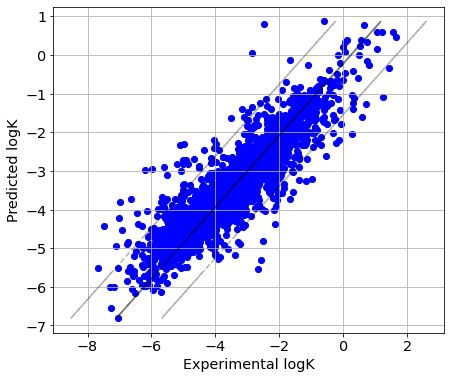

In [18]:
picture(Y_true, Y_pred)

### Transformation-out CV

Helper function for transformation-out and solvent-out CV

In [19]:
def grouper(cgrs, params): 
    """
    Helper function for transformation-out and solvent-out CV
    
    Parameters
    ----------
    cgrs: list
        The list dataset.
    params: list
        What we want to sort by.
        If these are solvents, then we transfer the general 
        name of the solvents in the meta data in square brackets.
        For example: ['additive.1']    
    Returns
    -------
    groups: tuple
        Tuple of parameters
    """
    groups = []
    for cgr in cgrs:
        group = tuple(cgr.meta[param] for param in params)
        groups.append(group)
    return groups

&lsquo;**Transformation-out&rsquo; CV**&nbsp;approach is&nbsp;implemented as&nbsp;a&nbsp;k-fold cross-validation (Figure&nbsp;1). In&nbsp;the &lsquo;transformation-out&rsquo; procedure, all reactions having the same CGR are placed into the same fold (different shapes in&nbsp;Figure&nbsp;1). The implemented splitting algorithm tries to&nbsp;make the folds approximately equal in&nbsp;size. Therefore, a&nbsp;fold might contain a&nbsp;group of&nbsp;several CGRs (as&nbsp;presented in&nbsp;fold 2, Figure&nbsp;1). Moreover, the test set contains reactions proceeding in&nbsp;the solvents presented also in&nbsp;the training set, see Figure&nbsp;1. This allows for avoiding a&nbsp;bias due to&nbsp;the presence of&nbsp;new solvents in&nbsp;the test set. Thus, unique reactions (corresponding to&nbsp;a&nbsp;unique combination of&nbsp;transformation and solvent) are always placed into the training set, see Figure&nbsp;1. Since in &lsquo;transformation-out&rsquo; validation all reactions having the same reactants and products are placed into the same subset (Figure&nbsp;1), this only shows how well reactions with new reactants and products, i.e. CGRs, are predicted.

<img src="img/validations.svg"/>
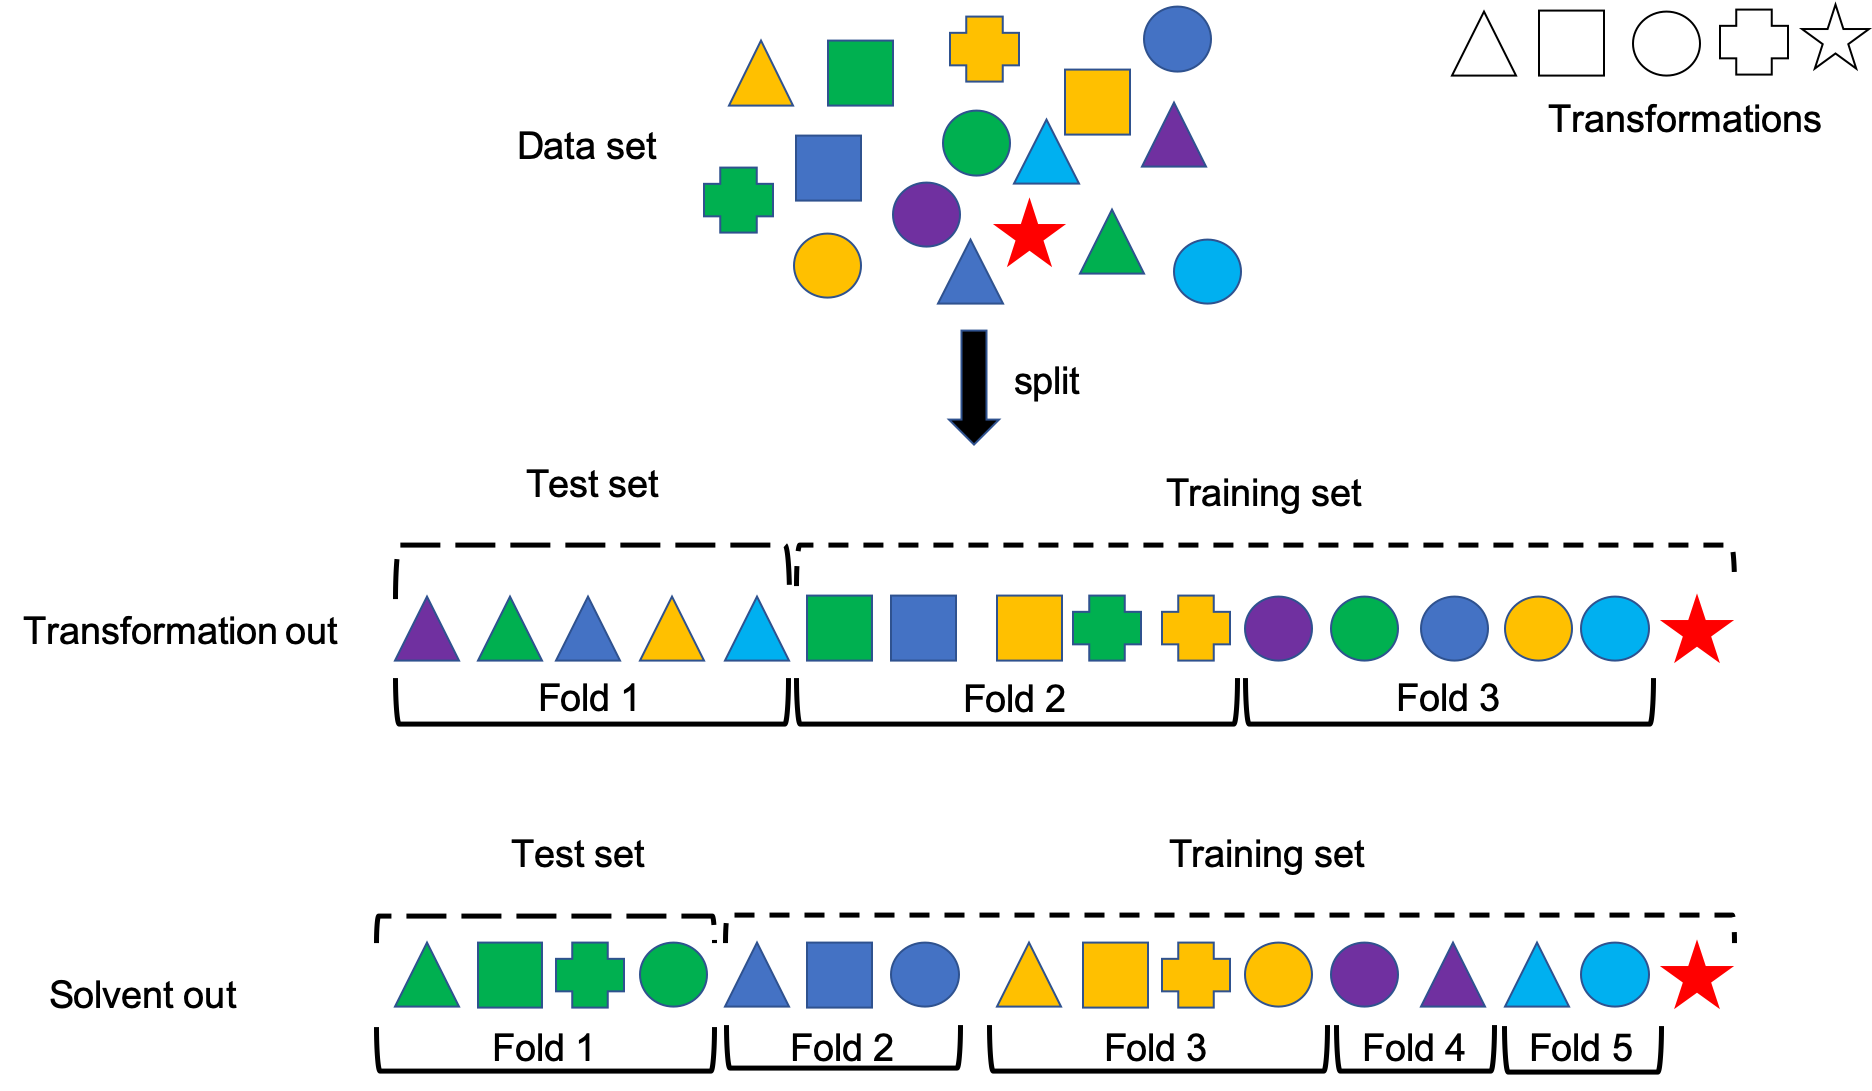

In [20]:
from CIMtools.model_selection import TransformationOut

In [21]:
groups = grouper(dataset, ['additive.1'])  

In [22]:
cv_tr = TransformationOut(n_splits=5, n_repeats=1, random_state=1, shuffle=True)

In [23]:
Y_true_tr, Y_pred_tr = [], []

for train_index, test_index in cv_tr.split(X=dataset, groups=groups):
    x_train = X[train_index]
    x_test = X[test_index]
    y_train = Y[train_index]
    y_test = Y[test_index]
    Y_true_tr.extend(y_test)
    Y_pred_tr.extend(RandomForestRegressor(random_state=1, n_estimators=500,
                                           n_jobs=-1).fit(x_train, y_train).predict(x_test))

In [24]:
print('Q2 = {}'.format(round(r2_score(Y_true_tr, Y_pred_tr),3)))
print('RMSE = {}'.format(round(mean_squared_error(Y_true_tr, Y_pred_tr, squared=False),3)))

Q2 = 0.563
RMSE = 0.77


In **&lsquo;transformation-out&rsquo; CV**&nbsp;strategy, all reactions with the same structural transformation are present in&nbsp;either the training or&nbsp;the test sets, but not both simultaneously. Therefore, RMSE values are bigger than for **&lsquo;reaction-out&rsquo; CV**&nbsp;strategy, but they remain on&nbsp;the acceptable levels.

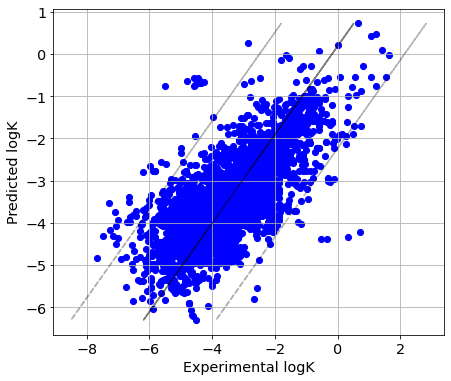

In [25]:
picture(Y_true_tr, Y_pred_tr)

### Solvent-out CV

&lsquo;**Solvent-out&rsquo;** validation approach is&nbsp;implemented as&nbsp;a&nbsp;leave-one-solvent-out (Figure&nbsp;1), as&nbsp;the number of&nbsp;solvent types is&nbsp;usually low (less than 50). An&nbsp;additional hurdle to&nbsp;the application of&nbsp;k-fold validation is&nbsp;caused by&nbsp;a&nbsp;great imbalance in&nbsp;the number of&nbsp;reactions corresponding to&nbsp;one solvent. In &lsquo;solvent-out&rsquo; validation, all reactions carried out in&nbsp;the same solvent are placed into the same subset which is&nbsp;sequentially used as&nbsp;the test set. Each reaction in&nbsp;the test set should have a&nbsp;counterpart in&nbsp;the training set with the same CGR but proceed in&nbsp;a&nbsp;different solvent. Unique reactions (in&nbsp;this case, reactions measured in&nbsp;a&nbsp;single solvent) are always included in&nbsp;the training set and never used in&nbsp;the test set. This method avoids underestimating of&nbsp;the model performance because such reactions represent new GCR and new solvent for the trained model. It&nbsp;is&nbsp;worth noting that we&nbsp;can group not only by&nbsp;solvents but also following several conditions.

In [26]:
from CIMtools.model_selection import LeaveOneGroupOut

In [27]:
cv_solv = LeaveOneGroupOut()

In [28]:
Y_true_solv, Y_pred_solv = [], []

for train_index, test_index in cv_solv.split(X=dataset, groups=groups): # we group the folds by solvents only
    x_train = X[train_index]
    x_test = X[test_index]
    y_train = Y[train_index]
    y_test = Y[test_index]
    Y_true_solv.extend(y_test)
    Y_pred_solv.extend(RandomForestRegressor(random_state=1, n_estimators=500,
                                             n_jobs=-1).fit(x_train, y_train).predict(x_test))

In [29]:
print('Q2 = {}'.format(round(r2_score(Y_true_solv, Y_pred_solv),3)))
print('RMSE = {}'.format(round(mean_squared_error(Y_true_solv, Y_pred_solv, squared=False),3)))

Q2 = 0.375
RMSE = 0.96


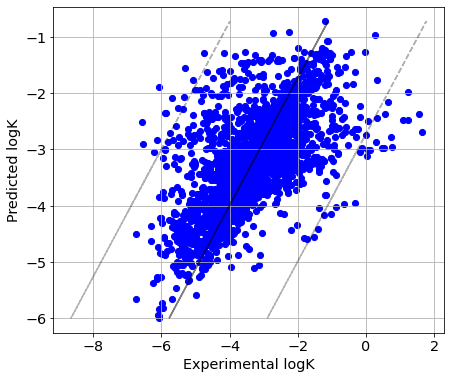

In [30]:
picture(Y_true_solv, Y_pred_solv)